## **Future analysis of agricultural land fertility in Europe and Asia.**
## Rice yield and production forecast.

## Import libraries and modules 

This section includes import of
* Python libraries
* modules available in the repository

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os

sys.path.append("/app/")
from src import load_data, utils
from src.models.yield_regression import regression
from sklearn.utils import resample
from typing import Dict
import xgboost as xgb
import seaborn as sns

import pandas as pd
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

from sklearn.model_selection import RandomizedSearchCV, GroupKFold

## Data source 

All the data used in research was obtained with Gogle Earth Engine.

Nevertheless, to simplify the access we loaded all data to [Google Drive folder](https://drive.google.com/drive/folders/1reYmmjR6ckznwakdeLyAC6DVKp3Adp2y?usp=sharing). Below this folder is refered to as `path`.

In [2]:
# Set the path do data folders
path = "/app/data/"
path_faostat = "/app/data/00-raw/FAOSTAT"

# FAOSTAT file names
data_production = "product_all.csv"
data_area_arable = "area_sums_all.csv"
data_area_crops = "area_all.csv"
data_fertilizers = "fert_all.csv"

# Data from climate model
crop_changes = "/app/data/03-results/model_climate_lc/crops_negative_2021_2028.pickle"
crop_over_changes = (
    "/app/data/03-results/model_climate_lc/crops_overall_2021_2028.pickle"
)

Next, we define the list of countries, climate variables, crops

In [3]:
country_names = [
    "Cambodia",
    "Indonesia",
    "Lao PDR",
    "Malaysia",
    "Myanmar",
    "Philippines",
    "Thailand",
    "Viet Nam",
    "Japan",
    "Korea",
    "Bangladesh",
]
prefixes = [
    "KHM",
    "IDN",
    "LAO",
    "MYS",
    "MMR",
    "PHL",
    "THA",
    "VNM",
    "JPN",
    "KOR",
    "BGD",
]

# Climate variables
vars = ["pr", "tmmx", "tmmn"]  # "pr",

# CMIP models in use
CMIPs = ["CNRM-CM5", "GFDL-CM3", "MPI-ESM-MR"]

# Crop variables
crops = ["Wheat", "Maize", "Soya", "Rice"]

# Fertilizer variables
fert = ["N", "P2O5", "K2O"]

# Count countries
n_count = len(prefixes)

# Count features
n_feat = (
    len(vars) * 2 * 12 + n_count * 2 + len(crops) + len(fert)
)  # 12 stand for months

#### Set dates

Here the user specifies the desired year_rice for the analysis. If the data was taken from Google Drive linked above, please pay attention on year_rice ranges available (listed in [README file](https://github.com/DariaTan/ArableLand2/blob/main/README.md)).

In [4]:
# Historical period available in data
years = np.arange(1966, 2022)  # for data collection, last year excluded
years_rice = np.arange(1966, 2022)  # for rice forecast model, last year excluded
# Future period
year_future = [2028]

Climate dataset is collected withing country borders and includes means of precipitation, maximum and minimum temperatures distribution in each month along with their variances. I could be either historical (TerraClimate) or future (CMIP5) data.

Since we've obtained prediction related to change in arable lands for each country, here we load the dictionary with that numbers.

In [5]:
# climate path
climate_path = os.path.join(path, "01-prepared/Economics/Climate_stat.pickle")

# Check if the file exists
if os.path.exists(climate_path):
    # If the file exists, load Climate data from the pickle file
    with open(climate_path, "rb") as handle:
        Climate = pickle.load(handle)
else:
    # If the file doesn't exist, load Climate data using load_data function
    Climate = load_data.climate_for_yield(
        path, prefixes, country_names, vars, years, year_future, CMIPs
    )
    # Save Climate data to a pickle file
    with open(climate_path, "wb") as handle:
        pickle.dump(Climate, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(crop_changes, "rb") as handle:
    neg_trend = pickle.load(handle)
with open(crop_over_changes, "rb") as handle:
    over_trend = pickle.load(handle)

FAOSTAT data gives the total area of arable lands of every country and its consumpion of fertilizers. Here we will divide one by another to get the fertilizers consumption per unit area. 

In [6]:
# Crop area
Total_area = load_data.arable_area(
    path_faostat,
    data_area_arable,
    data_area_crops,
    prefixes,
    country_names,
    years,
    crops,
)

# Fertilizers data
Fert = load_data.fertilizers(
    path_faostat, data_fertilizers, prefixes, country_names, years
)

## Fertilizers model

Here we replicate some last year_rice of data (set with n_year_rice parameter below) to repeat them with certan shify for future fertilizers consumpion, since it influences the yield. 

{'N': {'MAPE': 0.14571419482955117, 'MAE': 0.005324099492231091, 'RMSE': 0.005743256316693673}, 'P2O5': {'MAPE': 0.5667494848056885, 'MAE': 0.005488656538139187, 'RMSE': 0.006045013009234204}, 'K2O': {'MAPE': 196667544395.31348, 'MAE': 0.006630467049246059, 'RMSE': 0.007381926303842429}}
Mean MAPE: 65555848132.008644
Mean RMSE: 0.006390065209923436


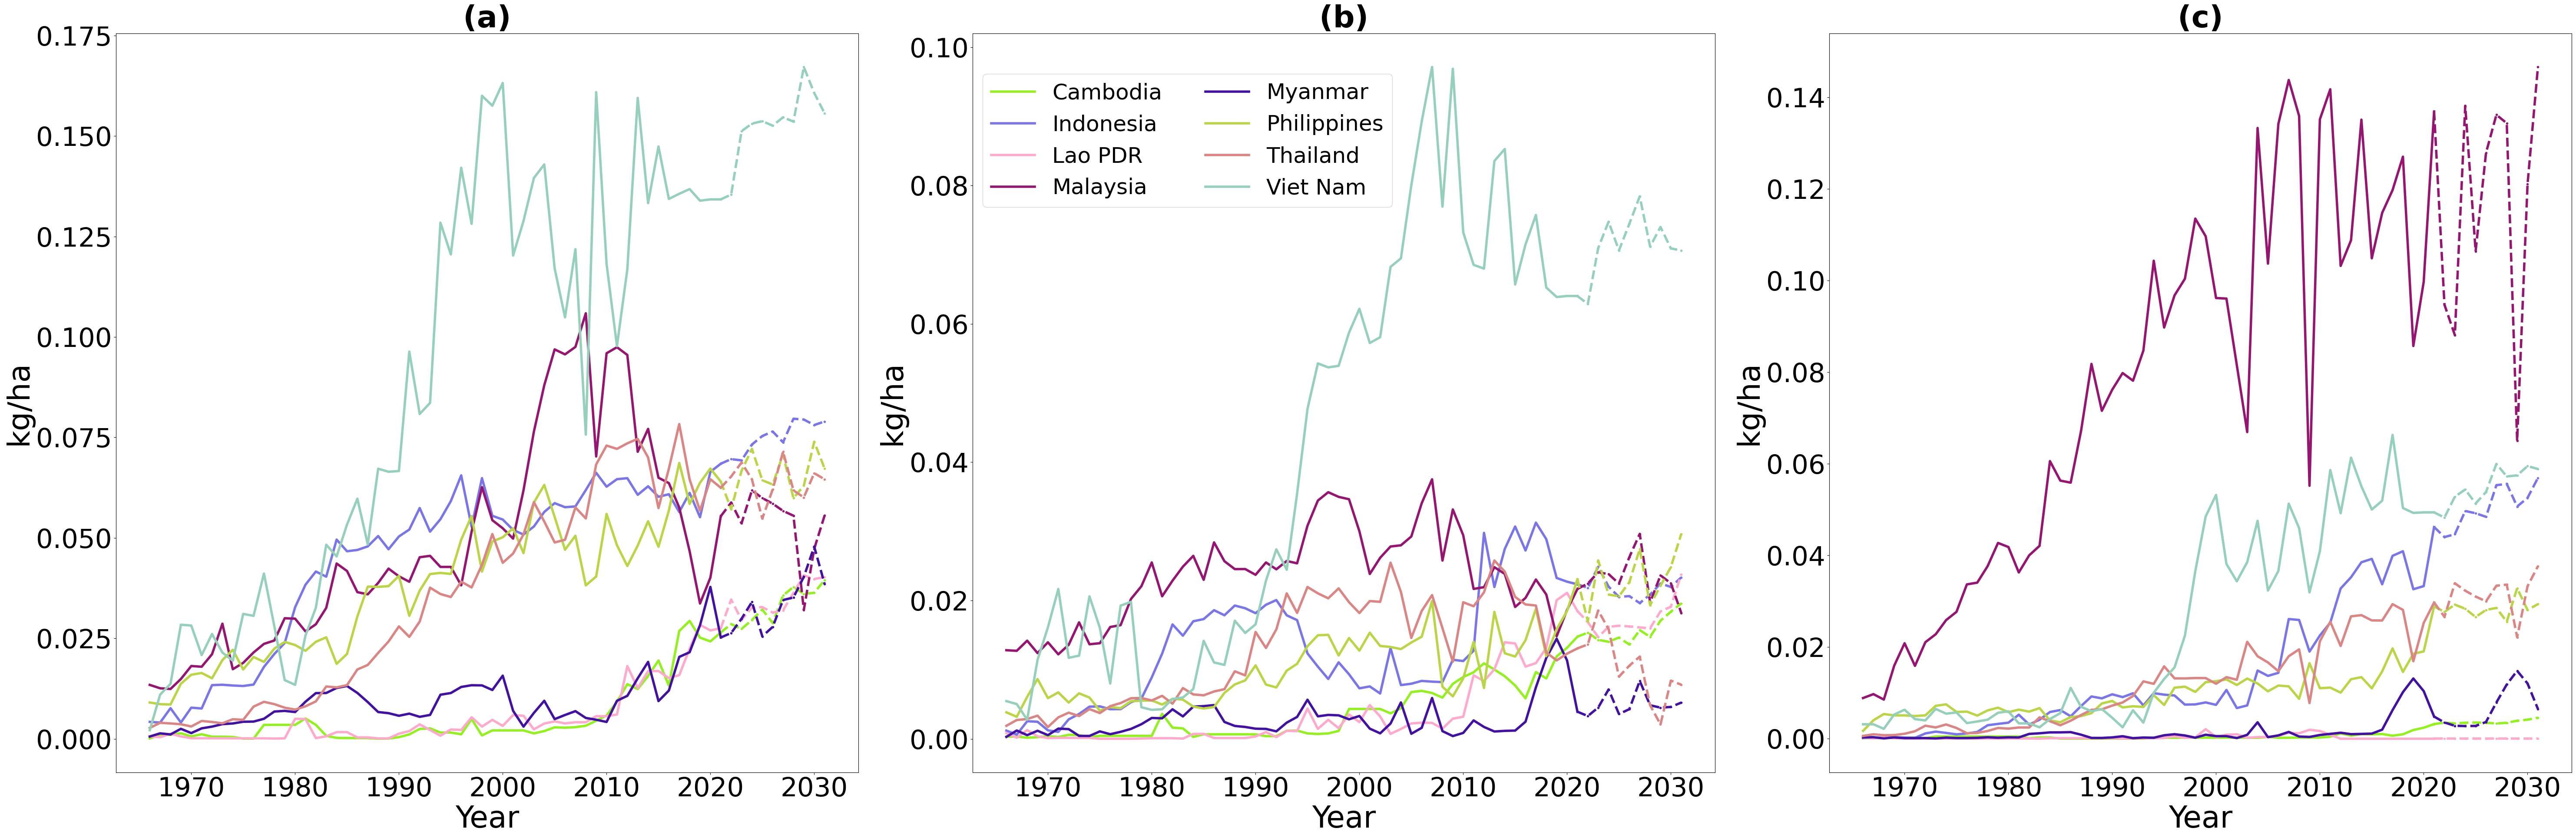

In [12]:
Fert_future = utils.fert_forecast(
    Fert, Total_area, prefixes, country_names, years, n_year_rice=10, method="SARIMA"
)

## Rice yield model

Before fitting the yield model we applied rolling mean to all historical data. In general it smoothes it a bit and improves the overall prediction.

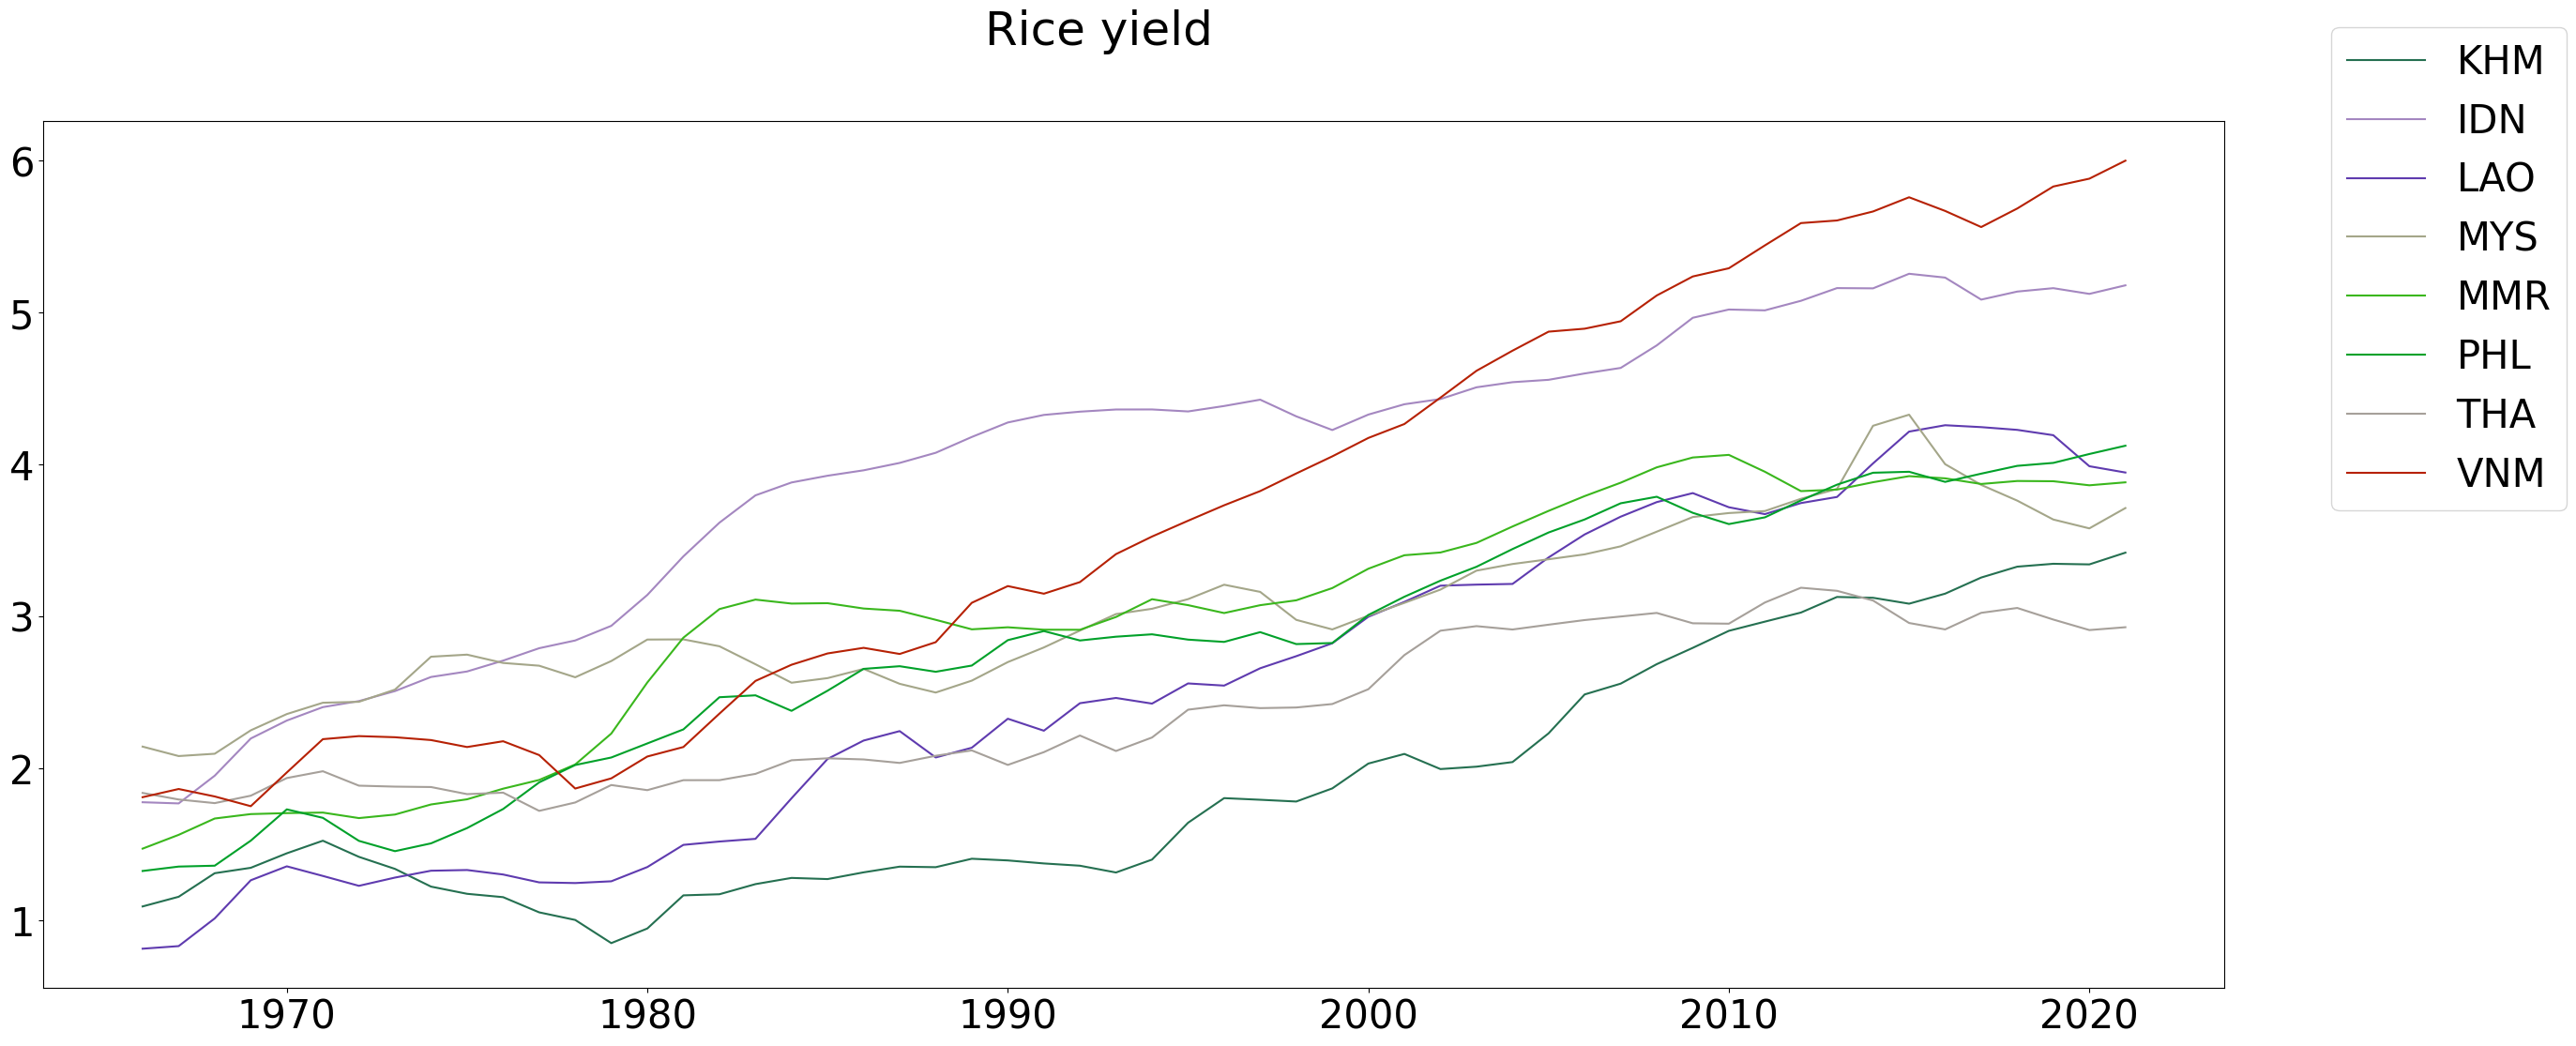

In [8]:
# Apply rolling mean to yield data
Production = load_data.production(
    path_faostat, data_production, prefixes, country_names, Total_area, years
)
Yield = utils.yield_rolling_mean(Production, prefixes, years, window=2)

With all data avilable it is time to collect train and test sets for all crops and extract samples with rice only for our task.

In [9]:
# Collect data for train and test
n_years_test = 2  # last years for test
X_train, Y_train, X_test, Y_test = utils.collect_data_yield(
    path_faostat,
    data_production,
    prefixes,
    country_names,
    Climate,
    Fert,
    Yield,
    Total_area,
    n_years_test,
    crops,
    vars,
    years_rice,
    n_feat,
)

# Find data with rice as a crop
X_train_rice = X_train[X_train[:, -1] == 1][:, :-4]
Y_train_rice = Y_train[X_train[:, -1] == 1][:, 0].astype(float)
X_test_rice = X_test[X_test[:, -1] == 1][:, :-4]
Y_test_rice = Y_test[X_test[:, -1] == 1][:, 0].astype(float)
print("Rice #samples", X_train_rice.shape)

Rice #samples (253, 97)


The similar procedure run for future data.

In [10]:
X_future_rice = utils.collect_future_data(
    path_faostat,
    data_production,
    prefixes,
    country_names,
    Climate,
    CMIPs,
    Fert_future,
    crops,
    vars,
    years_rice,
    year_future,
    n_feat,
)

For more informative representation we collect the feature names and show it like a dataframe for few first samples.

In [11]:
columns = []
for var in vars:
    for month in range(1, 13):
        columns.append(var + "_" + str(month))
        columns.append(var + "_" + str(month) + "_var")
for f in fert:
    columns.append(f)
for prefix in prefixes:
    columns.append("Trend_" + prefix)
for prefix in prefixes:
    columns.append(prefix)

df_f = pd.DataFrame(X_train_rice, columns=columns)
df_future = pd.DataFrame(X_future_rice["GFDL-CM3"], columns=columns)
df_f.iloc[:5, :]

,pr_1,pr_1_var,pr_2,pr_2_var,pr_3,pr_3_var,pr_4,pr_4_var,pr_5,pr_5_var,...,IDN,LAO,MYS,MMR,PHL,THA,VNM,JPN,KOR,BGD
0,5.284247,56.207230,8.593675,115.264618,27.737244,1473.152222,49.686810,3812.090088,81.521873,10073.278320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,10.678890,201.594650,13.638479,365.721527,43.181206,3228.538818,65.445389,7562.391113,92.945358,12241.740234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.119510,0.152117,0.032004,0.031281,2.004280,23.001352,15.581359,631.224915,127.266357,23778.316406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,10.792573,209.714081,10.597078,167.148743,30.787804,2406.561523,67.477074,7500.228516,171.654068,53110.816406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.521886,0.898862,3.232760,20.407022,13.308632,320.667938,36.374226,3571.643066,152.420074,37747.429688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Fitting the regression model for yield prediction.

In [12]:
max_depth = 2
n_estimators=100

# Confidence Level
CL = 0.90
alphaUpper = CL + (1 - CL)/2
alphaLower = (1 - CL)/2
print(alphaUpper*100, alphaLower*100)

95.0 4.999999999999999


In [13]:
# upper percentile
modelUp = xgb.XGBRegressor(objective=utils.log_cosh_quantile(alpha=0.95), max_depth=max_depth, n_estimators=n_estimators)
modelUp.fit(
    X_train_rice,
    Y_train_rice,
    eval_set=[(X_train_rice, Y_train_rice), (X_test_rice, Y_test_rice)],
    eval_metric=utils.meanPinBallLossUpper,
    verbose=False,
)
resultsUp = modelUp.evals_result()

# lower percentile
modelLow = xgb.XGBRegressor(
    objective=utils.log_cosh_quantile(alpha=0.05), max_depth=max_depth, n_estimators=n_estimators
)
modelLow.fit(
    X_train_rice,
    Y_train_rice,
    eval_set=[(X_train_rice, Y_train_rice), (X_test_rice, Y_test_rice)],
    eval_metric=utils.meanPinBallLossLower,
    verbose=False,
)
resultsLow = modelLow.evals_result()

# prediction
modelMid = xgb.XGBRegressor(max_depth=max_depth, n_estimators=n_estimators)
modelMid.fit(X_train_rice, Y_train_rice)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
preds_train = modelMid.predict(X_train_rice)
r2_s = r2_score(Y_train_rice, preds_train)
mse = mean_squared_error(Y_train_rice, preds_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_train_rice, preds_train)
mape = mean_absolute_percentage_error(preds_train, Y_train_rice)

print("MidModel [MSE]_train: ", mse)
print("MidModel [RMSE]_train: ", rmse)
print("MidModel [MAE]_train: ", mae)
print("MidModel [R2]_train: ", r2_s)
print("MidModel [MAPE]_train: ", mape)

preds_test = modelMid.predict(X_test_rice)
r2_s = r2_score(Y_test_rice, preds_test)
mse = mean_squared_error(Y_test_rice, preds_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_rice, preds_test)
mape = mean_absolute_percentage_error(preds_test, Y_test_rice)

print("MidModel [MSE]_test20%: ", mse)
print("MidModel [RMSE]_test20%: ", rmse)
print("MidModel [MAE]_test20%: ", mae)
print("MidModel [R2]_test20%: ", r2_s)
print("MidModel [MAPE]_test20%: ", mape)

MidModel [MSE]_train:  0.005129355295187602
MidModel [RMSE]_train:  0.07161951755762952
MidModel [MAE]_train:  0.050808692667272566
MidModel [R2]_train:  0.9971662658041088
MidModel [MAPE]_train:  0.015835598987031498
MidModel [MSE]_test20%:  0.04306996408818599
MidModel [RMSE]_test20%:  0.20753304336463144
MidModel [MAE]_test20%:  0.1669658527082674
MidModel [R2]_test20%:  0.9781564894994162
MidModel [MAPE]_test20%:  0.04224787054702375


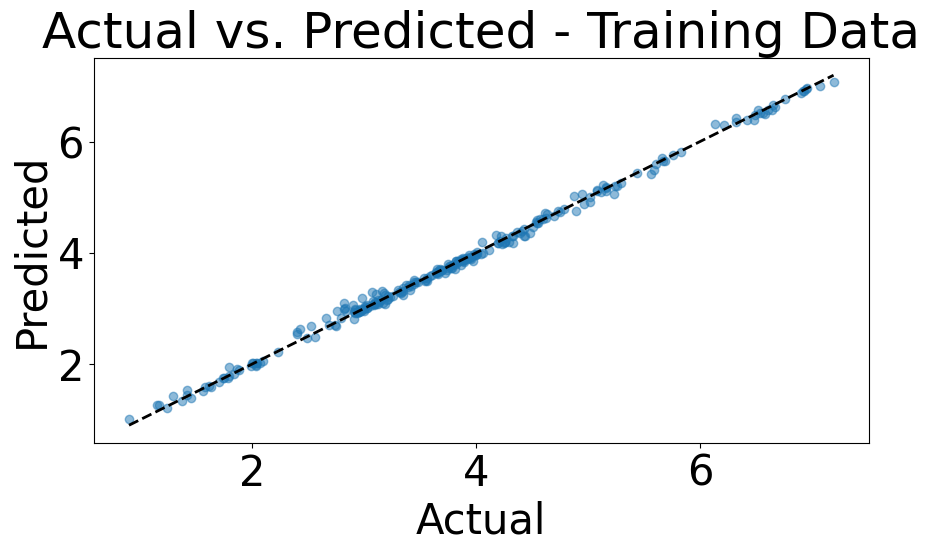

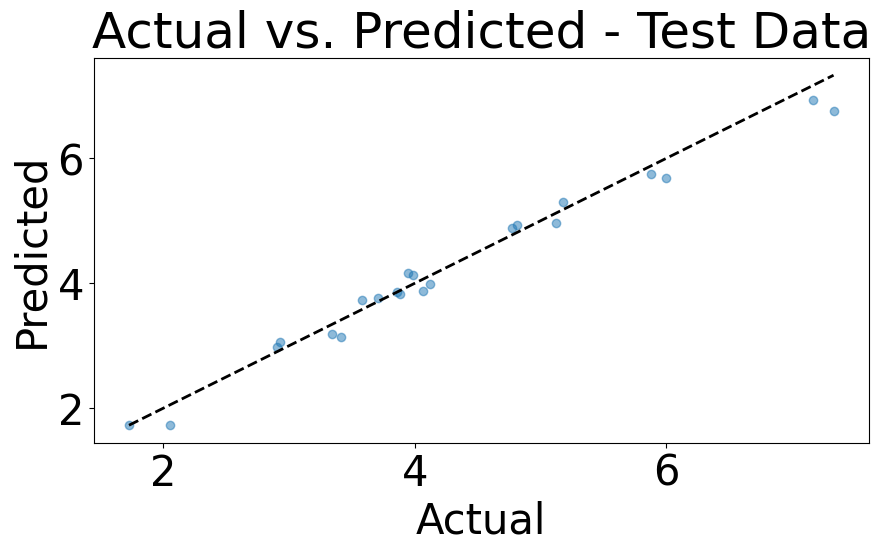

In [15]:
# Plot for Training Data
plt.figure(figsize=(10, 5))
plt.scatter(Y_train_rice, preds_train, alpha=0.5)
plt.plot(
    [Y_train_rice.min(), Y_train_rice.max()],
    [Y_train_rice.min(), Y_train_rice.max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted - Training Data")
plt.show()

# Plot for Test Data
plt.figure(figsize=(10, 5))
plt.scatter(Y_test_rice, preds_test, alpha=0.5)
plt.plot(
    [Y_test_rice.min(), Y_test_rice.max()],
    [Y_test_rice.min(), Y_test_rice.max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted - Test Data")
plt.show()

Next table shows the evaluation of the model for several countries.

Area resuction comes from the crop model as was menioned before. historical yield and producion are taken from FAOSTAT, while their future yield is calculated with yield modeling and future producion is calculated based on it with the expected change in rice arable area. For the sake of simplicity we assume that any reduction in total arable lands entails the same reduction of area for every crop.

In [16]:
# Collect data for train and test
_, _, _, Y_base = utils.collect_data_yield(
    path_faostat,
    data_production,
    prefixes,
    country_names,
    Climate,
    Fert,
    Yield,
    Total_area,
    10,
    crops,
    vars,
    np.arange(2000, 2022),
    n_feat,
)

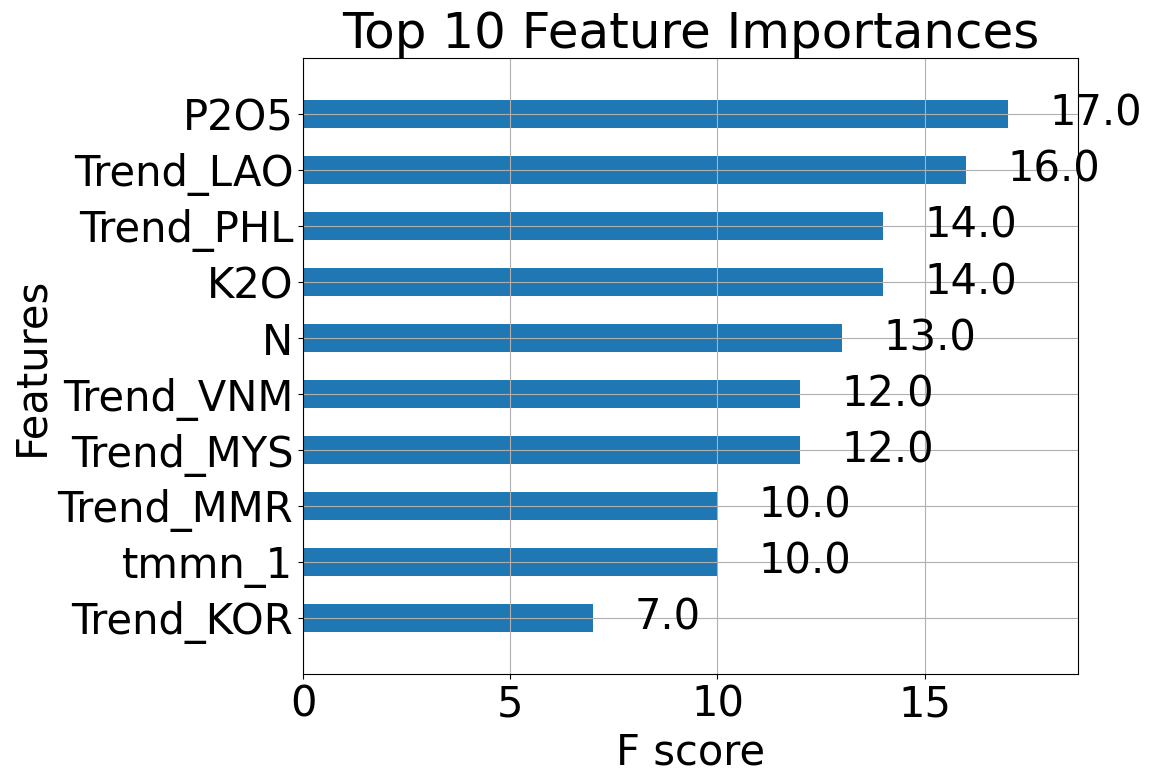

In [17]:
# Assign feature names to the model
modelMid.get_booster().feature_names = columns

# Plotting feature importances with correct feature names
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(
    modelMid,
    ax=ax,
    max_num_features=10,
    importance_type="weight",
    show_values=True,
    height=0.5,
)
plt.title("Top 10 Feature Importances")
plt.show()

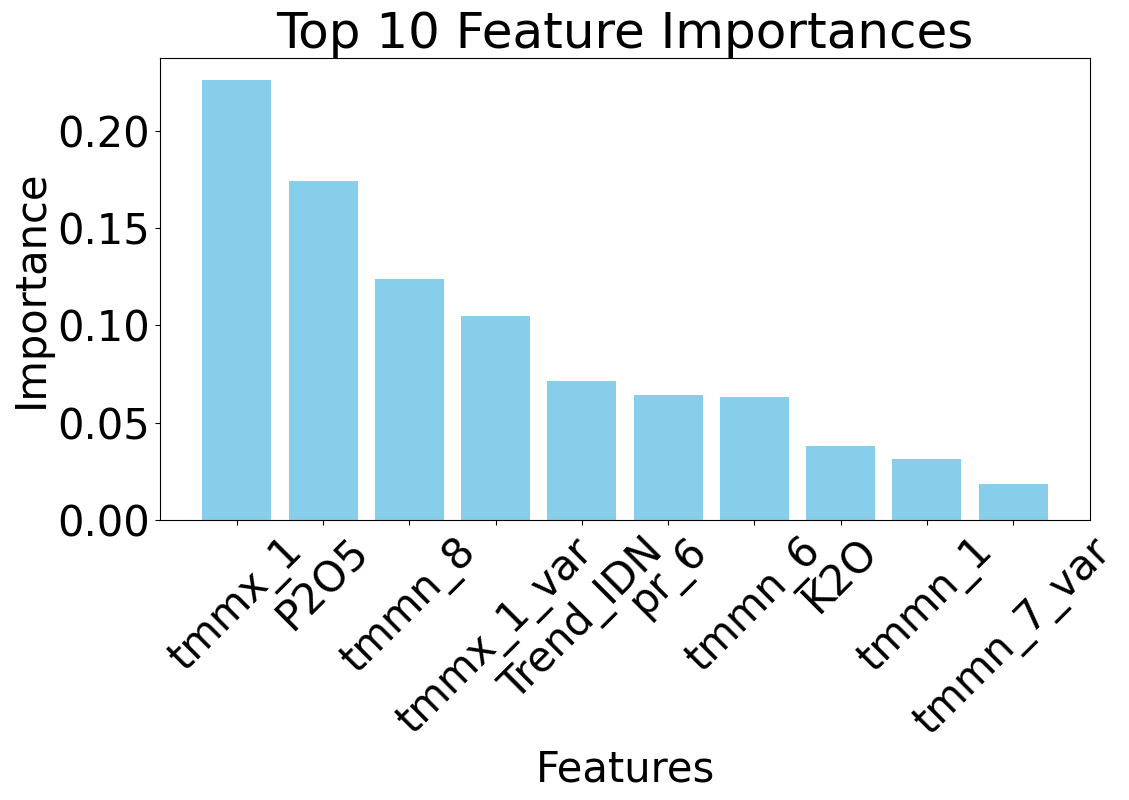

In [18]:
# Get feature importances
feature_importances = modelMid.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Use the columns list to map sorted index to feature names
sorted_feature_names = [columns[i] for i in indices[:10]]
top_importances = feature_importances[indices[:10]]

# Create a bar chart for the top 10 features
plt.figure(figsize=(12, 6))
plt.bar(sorted_feature_names, top_importances, color="skyblue")
plt.title("Top 10 Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

In [19]:
# Train with (train+test), predict with future data
n_iterations = 500
yield_future = {key: [] for key in prefixes}
n_count = len(prefixes)

for n in range(n_iterations):
    np.random.seed(n)
    X_bs, y_bs = resample(
        np.concatenate((X_train_rice, X_test_rice)),
        np.concatenate((Y_train_rice, Y_test_rice)),
        replace=True,
    )
    modelMid.fit(X_bs, y_bs)
    for i, prefix in enumerate(prefixes):
        X_future = sum(list(X_future_rice.values())) / len(CMIPs)
        X_future_local = X_future[X_future[:, -n_count + i] == 1]
        y_hat = modelMid.predict(X_future_local)
        yield_future[prefix].append(y_hat[0])

In [20]:
# Set the year to compare future with
year_base = 2021
df = utils.yield_outcome(
    yield_future,
    Y_base,
    X_future_rice,
    CMIPs,
    Total_area,
    neg_trend,
    prefixes,
    country_names,
    year_base,
)
df[
    df["Country"].isin(
        [
            "Cambodia",
            "Indonesia",
            "Lao PDR",
            "Malaysia",
            "Myanmar",
            "Philippines",
            "Thailand",
            "Viet Nam",
        ]
    )
]

,Country,Area_reduction,Yield_hist,Yield_future,Yield_ratio,Prod_hist,Prod_future,Prod_ratio
0,Cambodia,-1.1,3.42,2.97,-13.157894,11954544,10262957,-14.150159
1,Indonesia,-3.5,5.18,4.87,-5.984558,53902867,48973748,-9.144447
2,Lao PDR,-1.2,3.94,3.71,-5.837562,3385941,3143340,-7.164951
3,Malaysia,-0.9,3.71,3.67,-1.078165,2404526,2355565,-2.036202
4,Myanmar,-1.2,3.88,3.05,-21.391754,27331178,21192707,-22.459592
5,Philippines,-1.5,4.12,4.4,6.796119,19803703,20818614,5.124855
6,Thailand,-0.7,2.93,2.75,-6.143345,32675717,30487974,-6.695318
7,Viet Nam,-9.3,6.0,5.36,-10.666664,43301148,35128658,-18.87361


In [21]:
df = utils.yield_outcome(
    yield_future,
    Y_base,
    X_future_rice,
    CMIPs,
    Total_area,
    over_trend,
    prefixes,
    country_names,
    year_base,
)
df[
    df["Country"].isin(
        [
            "Cambodia",
            "Indonesia",
            "Lao PDR",
            "Malaysia",
            "Myanmar",
            "Philippines",
            "Thailand",
            "Viet Nam",
        ]
    )
]

,Country,Area_reduction,Yield_hist,Yield_future,Yield_ratio,Prod_hist,Prod_future,Prod_ratio
0,Cambodia,5.3,3.42,2.97,-13.157894,11954544,10927092,-8.594657
1,Indonesia,-2.5,5.18,4.87,-5.984558,53902867,49481248,-8.202938
2,Lao PDR,14.3,3.94,3.71,-5.837562,3385941,3636475,7.399243
3,Malaysia,0.9,3.71,3.67,-1.078165,2404526,2398350,-0.256849
4,Myanmar,2.4,3.88,3.05,-21.391754,27331178,21964911,-19.634232
5,Philippines,1.1,4.12,4.4,6.796119,19803703,21368140,7.89972
6,Thailand,10.1,2.93,2.75,-6.143345,32675717,33803886,3.452622
7,Viet Nam,-7.2,6.0,5.36,-10.666664,43301148,35942001,-16.99527


#### XGBR uncertainty with bootstrap

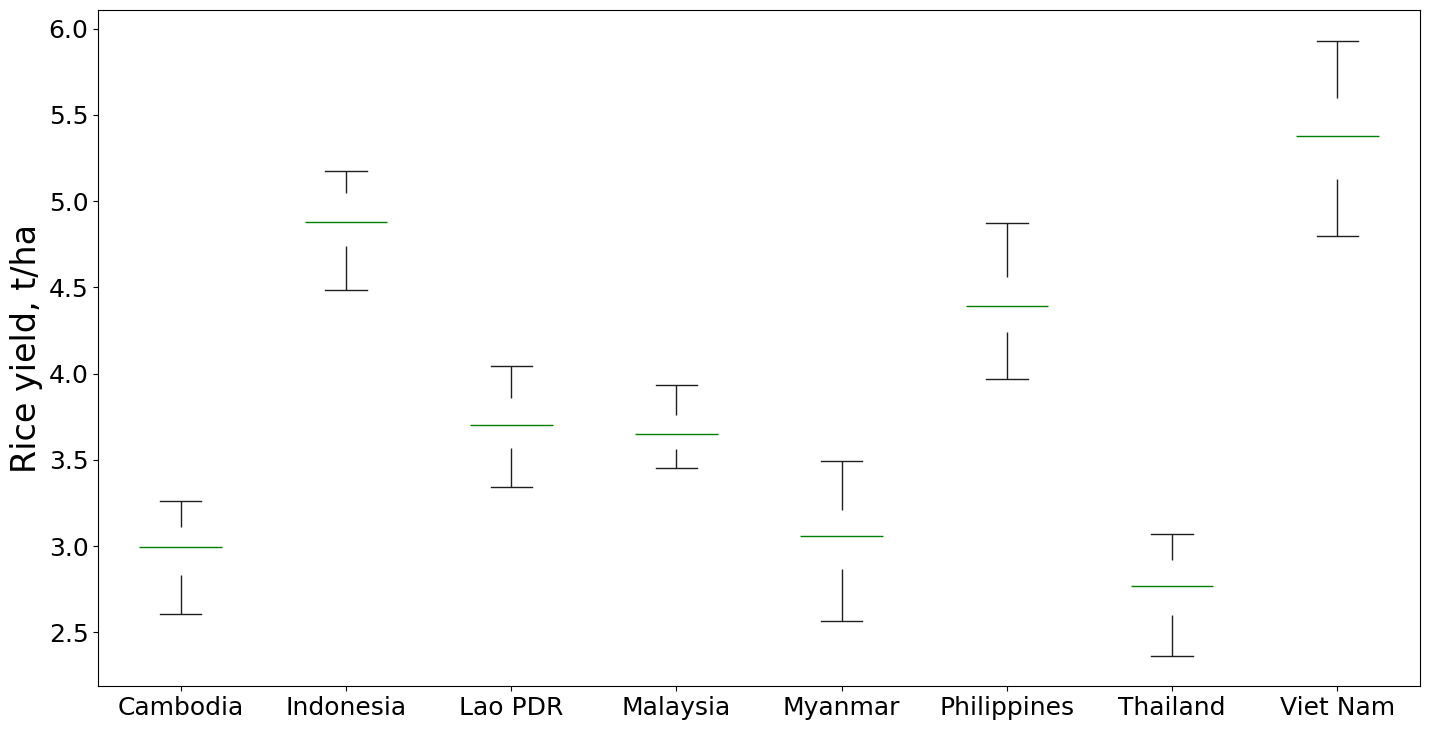

In [26]:
prefixes_SEA = ["KHM", "IDN", "LAO", "MYS", "MMR", "PHL", "THA", "VNM"]
countries_SEA = [
    "Cambodia",
    "Indonesia",
    "Lao PDR",
    "Malaysia",
    "Myanmar",
    "Philippines",
    "Thailand",
    "Viet Nam",
]
yield_future_SEA = {key: yield_future[key] for key in prefixes_SEA}

plt.figure(figsize=(15, 8))


ax = sns.boxplot(
    yield_future_SEA,
    palette="Greens",
    whis=(5, 95),
    showbox=False,
    showfliers=False,
    medianprops=dict(color="green"),  # , alpha=0.7),
    width=0.5,
)
# ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_ylabel("Rice yield, t/ha", fontsize=24)
ax.set_xticklabels(countries_SEA)
ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig("/app/data/03-results/pics/rice_uncert.jpg", bbox_inches="tight", dpi=500)

In [23]:
df = pd.DataFrame()
df["pred"] = modelMid.predict(X_test_rice)
df["Y_test"] = Y_test_rice
df["lower"] = modelLow.predict(X_test_rice)
# df['med'] = all_models["q 0.50"].inplace_predict(X_test_rice)
df["upper"] = modelUp.predict(X_test_rice)
df

,pred,Y_test,lower,upper
0,4.723716,4.774526,3.696946,7.312597
1,4.797900,4.813766,3.933517,7.312597
2,3.210111,3.340223,2.482436,3.294552
3,3.354183,3.417537,2.498826,3.294552
4,1.519248,2.055293,1.514048,1.674705
5,1.710726,1.729639,1.373408,1.826415
6,5.152877,5.120813,3.507666,7.312597
7,5.186406,5.177094,3.689437,7.312597
8,7.166129,7.165437,4.903445,8.309181
9,7.186974,7.328731,4.903445,8.309181
